In [1]:
from tensorflow import keras
import tensorflow

from keras.utils import to_categorical
from keras._tf_keras.keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
import os
import pandas as pd
import numpy as np

In [2]:
# Importing the dataset from kaggle
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jonathanoheix/face-expression-recognition-dataset")

print("Path to dataset files:", path)

100%|██████████| 121M/121M [00:01<00:00, 96.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/jonathanoheix/face-expression-recognition-dataset/versions/1


In [3]:
TRAIN_DIR = path+'/images/train'
TEST_DIR = path+'/images/validation'

In [4]:
def createdataframe(dir):
    image_paths = []
    labels = []
    for label in os.listdir(dir):
        for imagename in os.listdir(os.path.join(dir,label)):
            image_paths.append(os.path.join(dir,label,imagename))
            labels.append(label)
        print(label, "completed")
    return image_paths,labels

In [5]:
train = pd.DataFrame()
train['image'], train['label'] = createdataframe(TRAIN_DIR)

angry completed
disgust completed
fear completed
sad completed
surprise completed
happy completed
neutral completed


In [6]:
train

,image,label
0,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
1,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
2,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
3,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
4,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
...,...,...
28816,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
28817,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
28818,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
28819,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral


In [7]:
test = pd.DataFrame()
test['image'], test['label'] = createdataframe(TEST_DIR)

angry completed
disgust completed
fear completed
sad completed
surprise completed
happy completed
neutral completed


In [8]:
test

,image,label
0,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
1,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
2,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
3,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
4,/root/.cache/kagglehub/datasets/jonathanoheix/...,angry
...,...,...
7061,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
7062,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
7063,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral
7064,/root/.cache/kagglehub/datasets/jonathanoheix/...,neutral


In [9]:
from tqdm.notebook import tqdm

def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode = "grayscale")
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features),48,48,1)
    return features


In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/28821 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/7066 [00:00<?, ?it/s]

In [12]:
# Normalising the dataset
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
from sklearn.preprocessing import LabelEncoder

# Labeling the outputs to indexes
le = LabelEncoder()
le.fit(train['label'])

y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

# Having then oneHotEncoded to work with CNN
y_train = to_categorical(y_train,num_classes = 7)
y_test = to_categorical(y_test,num_classes = 7)

In [14]:
# Defining the model

model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(48,48,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(7, activation='softmax'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [15]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics=[tensorflow.keras.metrics.MeanAbsoluteError()] )

In [16]:
model.fit(x= x_train,y = y_train, batch_size = 128, epochs = 100, validation_data = (x_test,y_test))

Epoch 1/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 33s 93ms/step - loss: 1.8482 - mean_absolute_error: 0.2378 - val_loss: 1.8117 - val_mean_absolute_error: 0.2365
Epoch 2/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 20s 46ms/step - loss: 1.8166 - mean_absolute_error: 0.2366 - val_loss: 1.7801 - val_mean_absolute_error: 0.2342
Epoch 3/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 10s 46ms/step - loss: 1.7633 - mean_absolute_error: 0.2320 - val_loss: 1.6520 - val_mean_absolute_error: 0.2218
Epoch 4/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - loss: 1.6679 - mean_absolute_error: 0.2209 - val_loss: 1.4947 - val_mean_absolute_error: 0.1989
Epoch 5/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 46ms/step - loss: 1.5504 - mean_absolute_error: 0.2055 - val_loss: 1.3927 - val_mean_absolute_error: 0.1903
Epoch 6/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - loss: 1.4652 - mean_absolute_error: 0.1964 - val_loss: 1.3185 - val_mean_absolute_error: 0.1808
Epoch 7/100
226/226 ━━━━━━━━━━━━━━━━━━━━ 11s 48ms/step - loss: 1.4218 - mean_absol

In [19]:
# saving the models and using json to be used with opencv
model_json = model.to_json()
with open("EmotionDetector.json",'w') as json_file:
    json_file.write(model_json)
model.save("EmotionDetector.h5")

In [20]:
from keras.models import model_from_json

# Loading the previously trained models
json_file = open("EmotionDetector.json", "r")
model_json = json_file.read()
json_file.close()
model = model_from_json(model_json)
model.load_weights("EmotionDetector.h5")

In [23]:
# defining the labels
label = ['angry','disgust','fear','happy','neutral','sad','surprise']

def ef(image):
    img = load_img(image, color_mode = "grayscale")
    feature = np.array(img)
    feature = feature.reshape(1,48,48,1)
    return feature/255.0

In [25]:
import matplotlib.pyplot as plt
%matplotlib inline

original image is of sad
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
model prediction is  sad


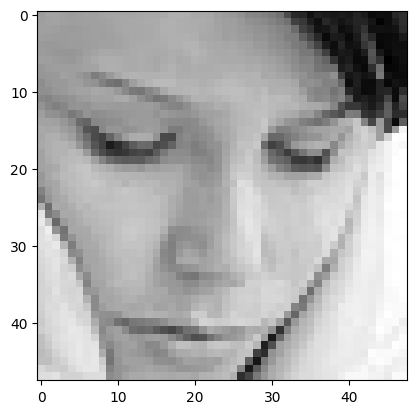

In [26]:
image = path+'/images/train/sad/42.jpg'
print("original image is of sad")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of fear
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
model prediction is  sad


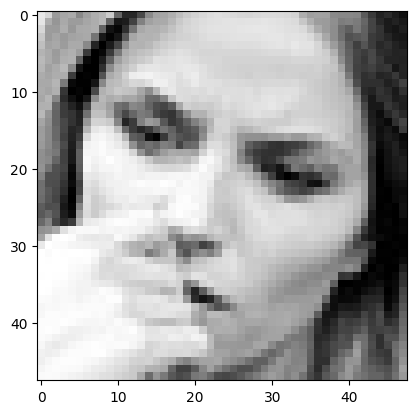

In [27]:
image = path+'/images/train/fear/2.jpg'
print("original image is of fear")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
model prediction is  disgust


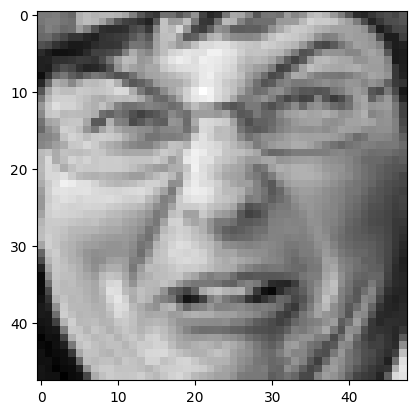

In [28]:
image = path+'/images/train/disgust/299.jpg'
print("original image is of disgust")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')

original image is of happy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
model prediction is  happy


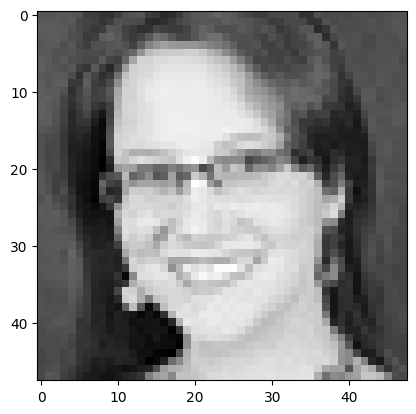

In [29]:
image = path+'/images/train/happy/7.jpg'
print("original image is of happy")
img = ef(image)
pred = model.predict(img)
pred_label = label[pred.argmax()]
print("model prediction is ",pred_label)
plt.imshow(img.reshape(48,48),cmap='gray')